In [1]:
#import dependencies
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt
#from tensorflow_probability.substrates.jax.internal.dtype_util

import pandas as pd
data = pd.read_pickle('/home/dkn16/data.pkl')
FGnopol = data.beam.foregrounds.all_nopol
FGpol = data.beam.foregrounds.pleak
HI = data.beam.HI
noise = data.beam.noise
freqs = data.freqs

from gpr4im import pk_tools as pk
import matplotlib.pyplot as plt
font = {"size": 18, "family": "sans-serif"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = False

In [2]:
cosmos = jnp.array(HI+noise)[0:256,0:256,0:256].astype(jnp.float64)
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))

pred_HGP = np.mean(np.load('/scratch/dkn16/result_hgp_pol.npy'),axis=0)*1000
pred_HGP_nopol = np.mean(np.load('/scratch/dkn16/result_hgp_nopol.npy'),axis=0)*1000
pred_CP = np.load('/scratch/dkn16/result_CP.npy')*1000
pred_NP = np.mean(np.load('/scratch/dkn16/result_np_pol_suppix1.npy'),axis=0)*1000

In [4]:
from kymatio.jax import HarmonicScattering3D

In [5]:
#calculating 6 scales, 7 angular directions. It's a little bit slow when generating ST kernels. Let's wait.
J = 6
L=6
M, N, O = 256, 256, 256


S = HarmonicScattering3D(J, (M, N, O),L=L,integral_powers=[1.0],)

In [6]:
#calculate the scattering coefficiens, and average over different Ls.
Scos = S(cosmos)
Scos = jnp.mean(Scos,axis = [1,2])

SCP = S(pred_CP)
SCP = jnp.mean(SCP,axis = [1,2])

SHGP = S(pred_HGP)
SHGP = jnp.mean(SHGP,axis = [1,2])

SHGP_np = S(pred_HGP_nopol)
SHGP_np = jnp.mean(SHGP_np,axis = [1,2])

SNP = S(pred_NP)
SNP = jnp.mean(SNP,axis = [1,2])

Text(0, 0.5, '$\\epsilon_{\\rm rel}$')

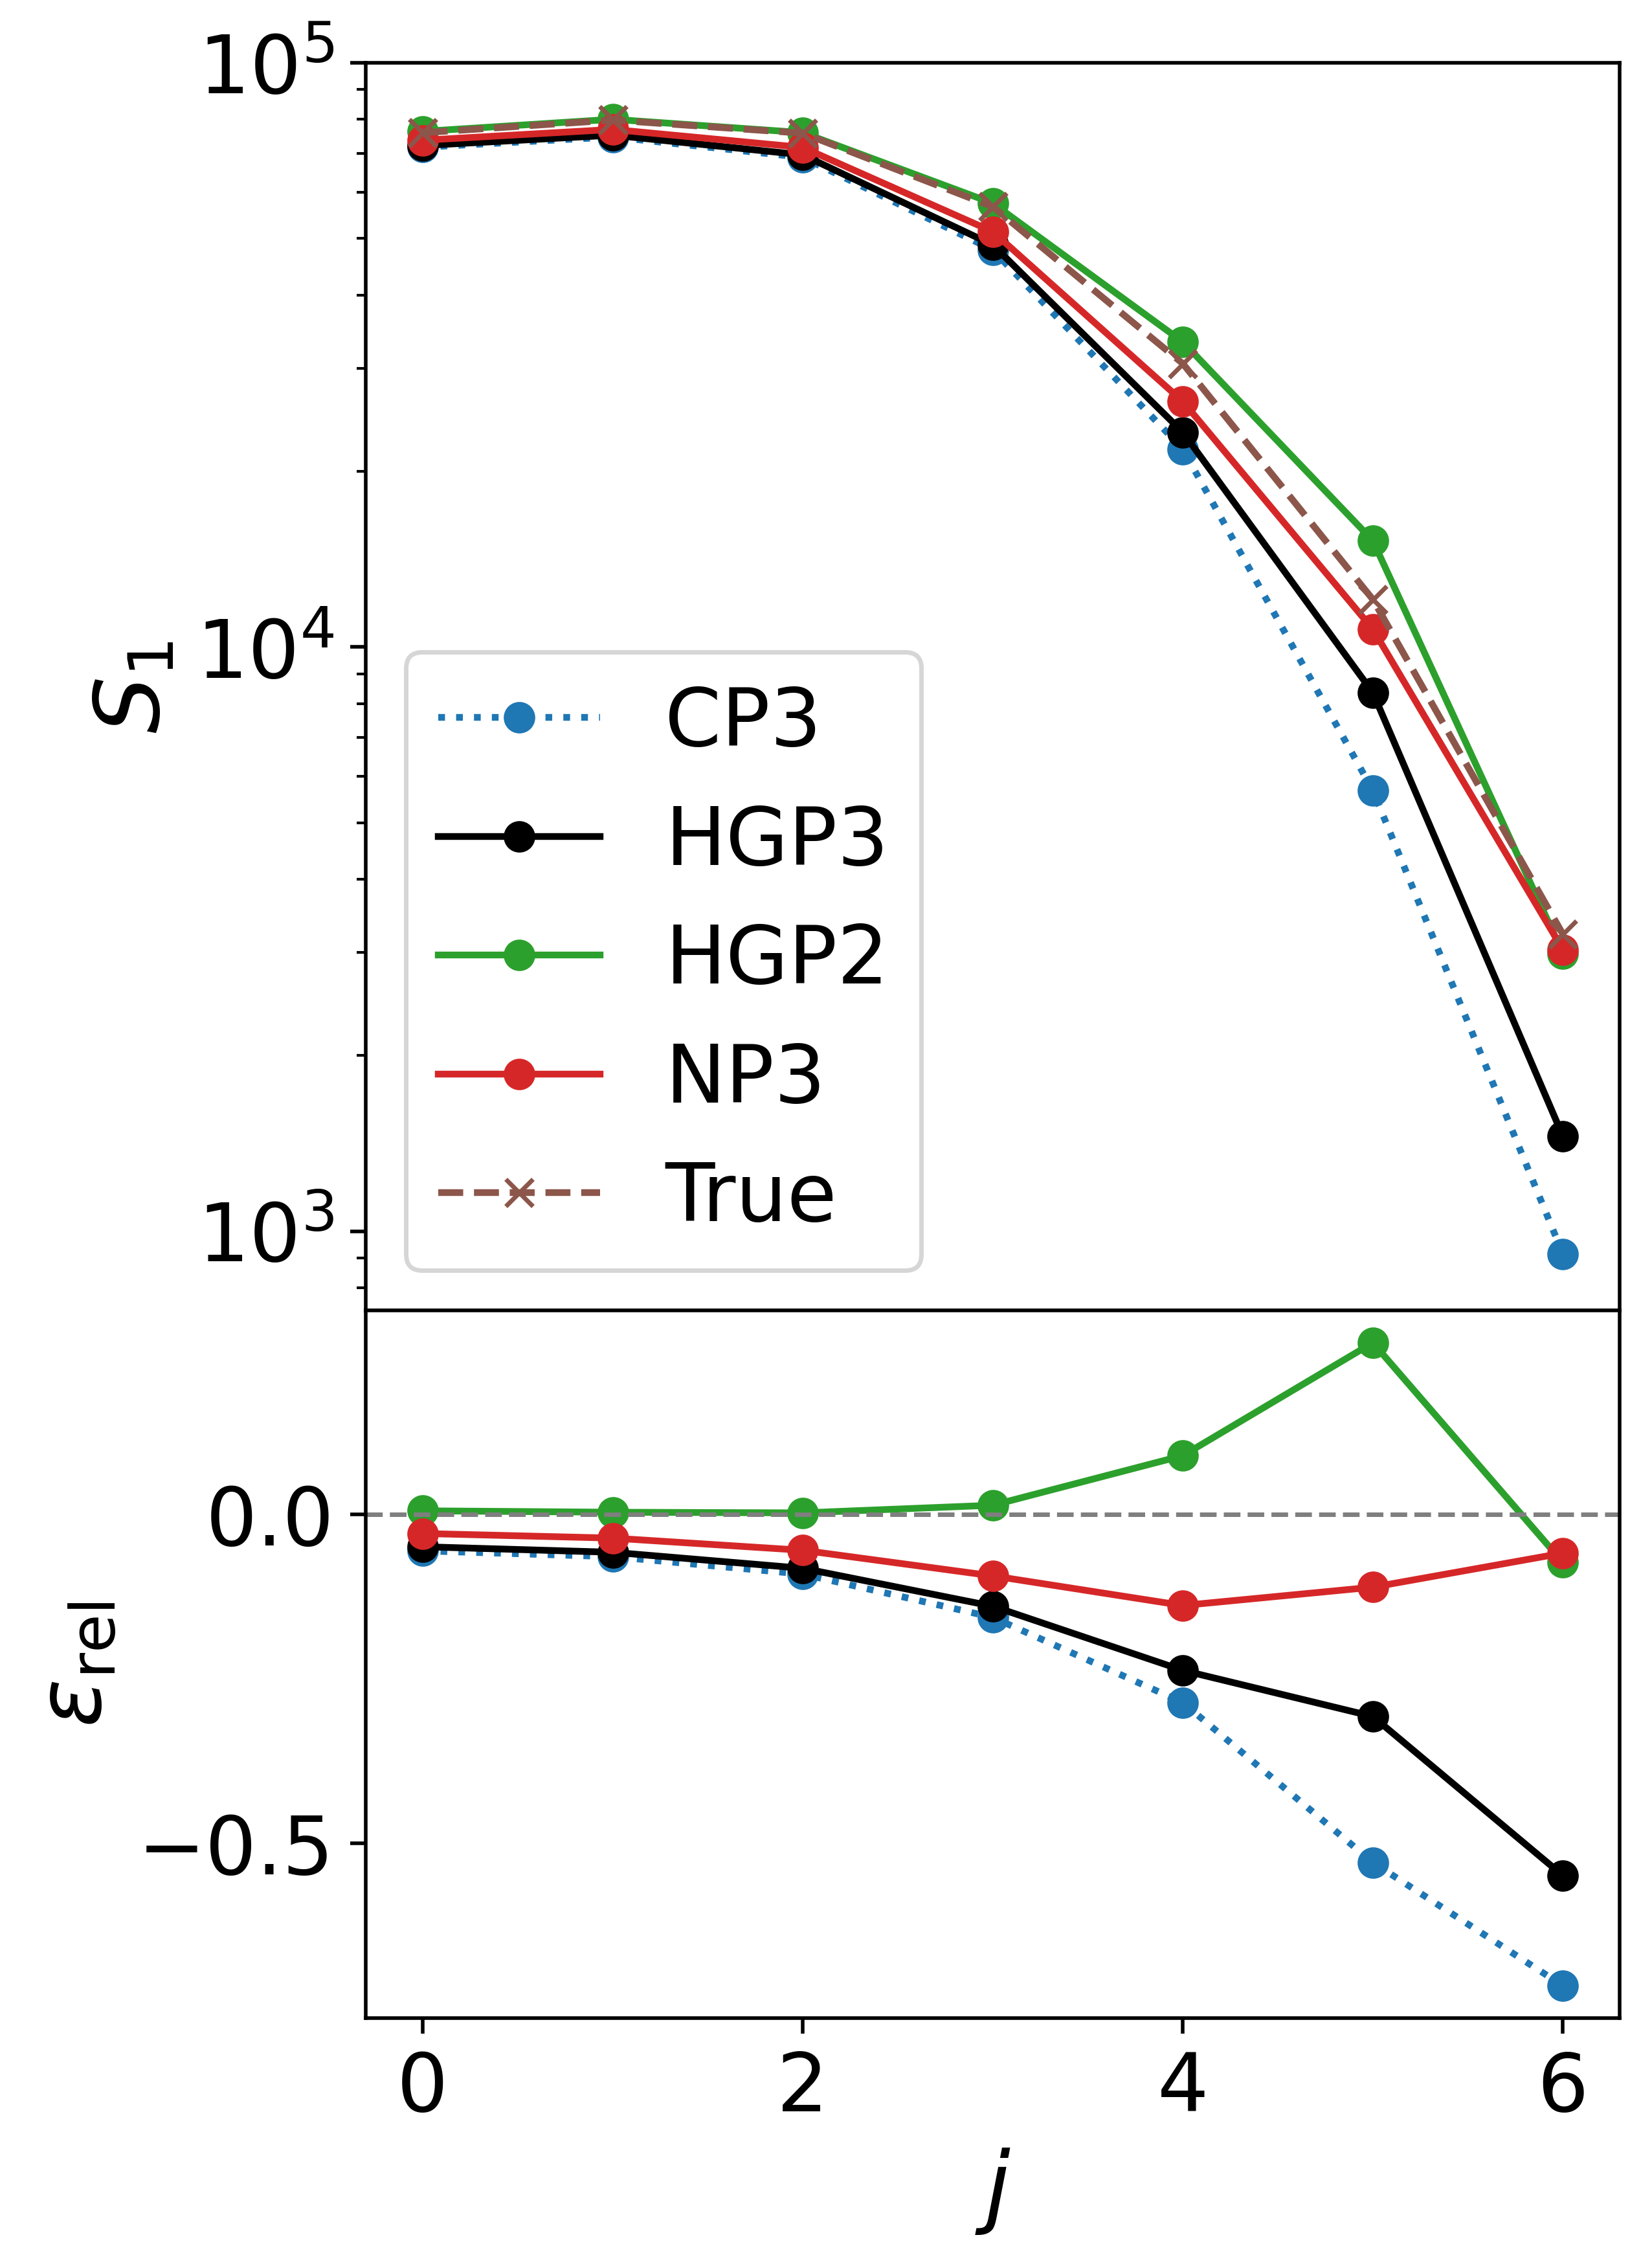

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex='col', 
                                                       figsize=(5,8), gridspec_kw={'height_ratios': [3, 1.7]},dpi=500)
fig.subplots_adjust(hspace=0, wspace=0.38)
J=6
ax1.semilogy(SCP[:J+1],marker = 'o',linestyle = ':')
ax1.semilogy(SHGP[:J+1],marker = 'o',color = 'black')
ax1.semilogy(SHGP_np[:J+1],marker = 'o',color = 'tab:green')
ax1.semilogy(SNP[:J+1],marker = 'o',color = 'tab:red')
ax1.semilogy(Scos[:J+1],linestyle = '--',color = '#8c564b',marker = 'x')
ax1.legend(['CP3','HGP3','HGP2','NP3','True'])
ax1.set_ylabel(r'$S_1$',fontsize=20)
ax2.set_xlabel(r'$j$',fontsize=20)

ax2.plot(SCP[:J+1]/Scos[:J+1]-1,marker = 'o',linestyle = ':')
ax2.plot(SHGP[:J+1]/Scos[:J+1]-1,marker = 'o',color = 'black')
ax2.plot(SHGP_np[:J+1]/Scos[:J+1]-1,marker = 'o',color = 'tab:green')
ax2.plot(SNP[:J+1]/Scos[:J+1]-1,marker = 'o',color = 'tab:red')
ax2.axhline(0.0,0,1,color = 'tab:grey',linewidth=1.,linestyle = '--')
#ax2.semilogy(Scos[:J+1],linestyle = '--',color = '#8c564b',marker = 'x')
ax2.set_ylabel(r'$\epsilon_{\rm rel}$',fontsize=20)
#plt.savefig('ST_s1.pdf',dpi=500,bbox_inches='tight')

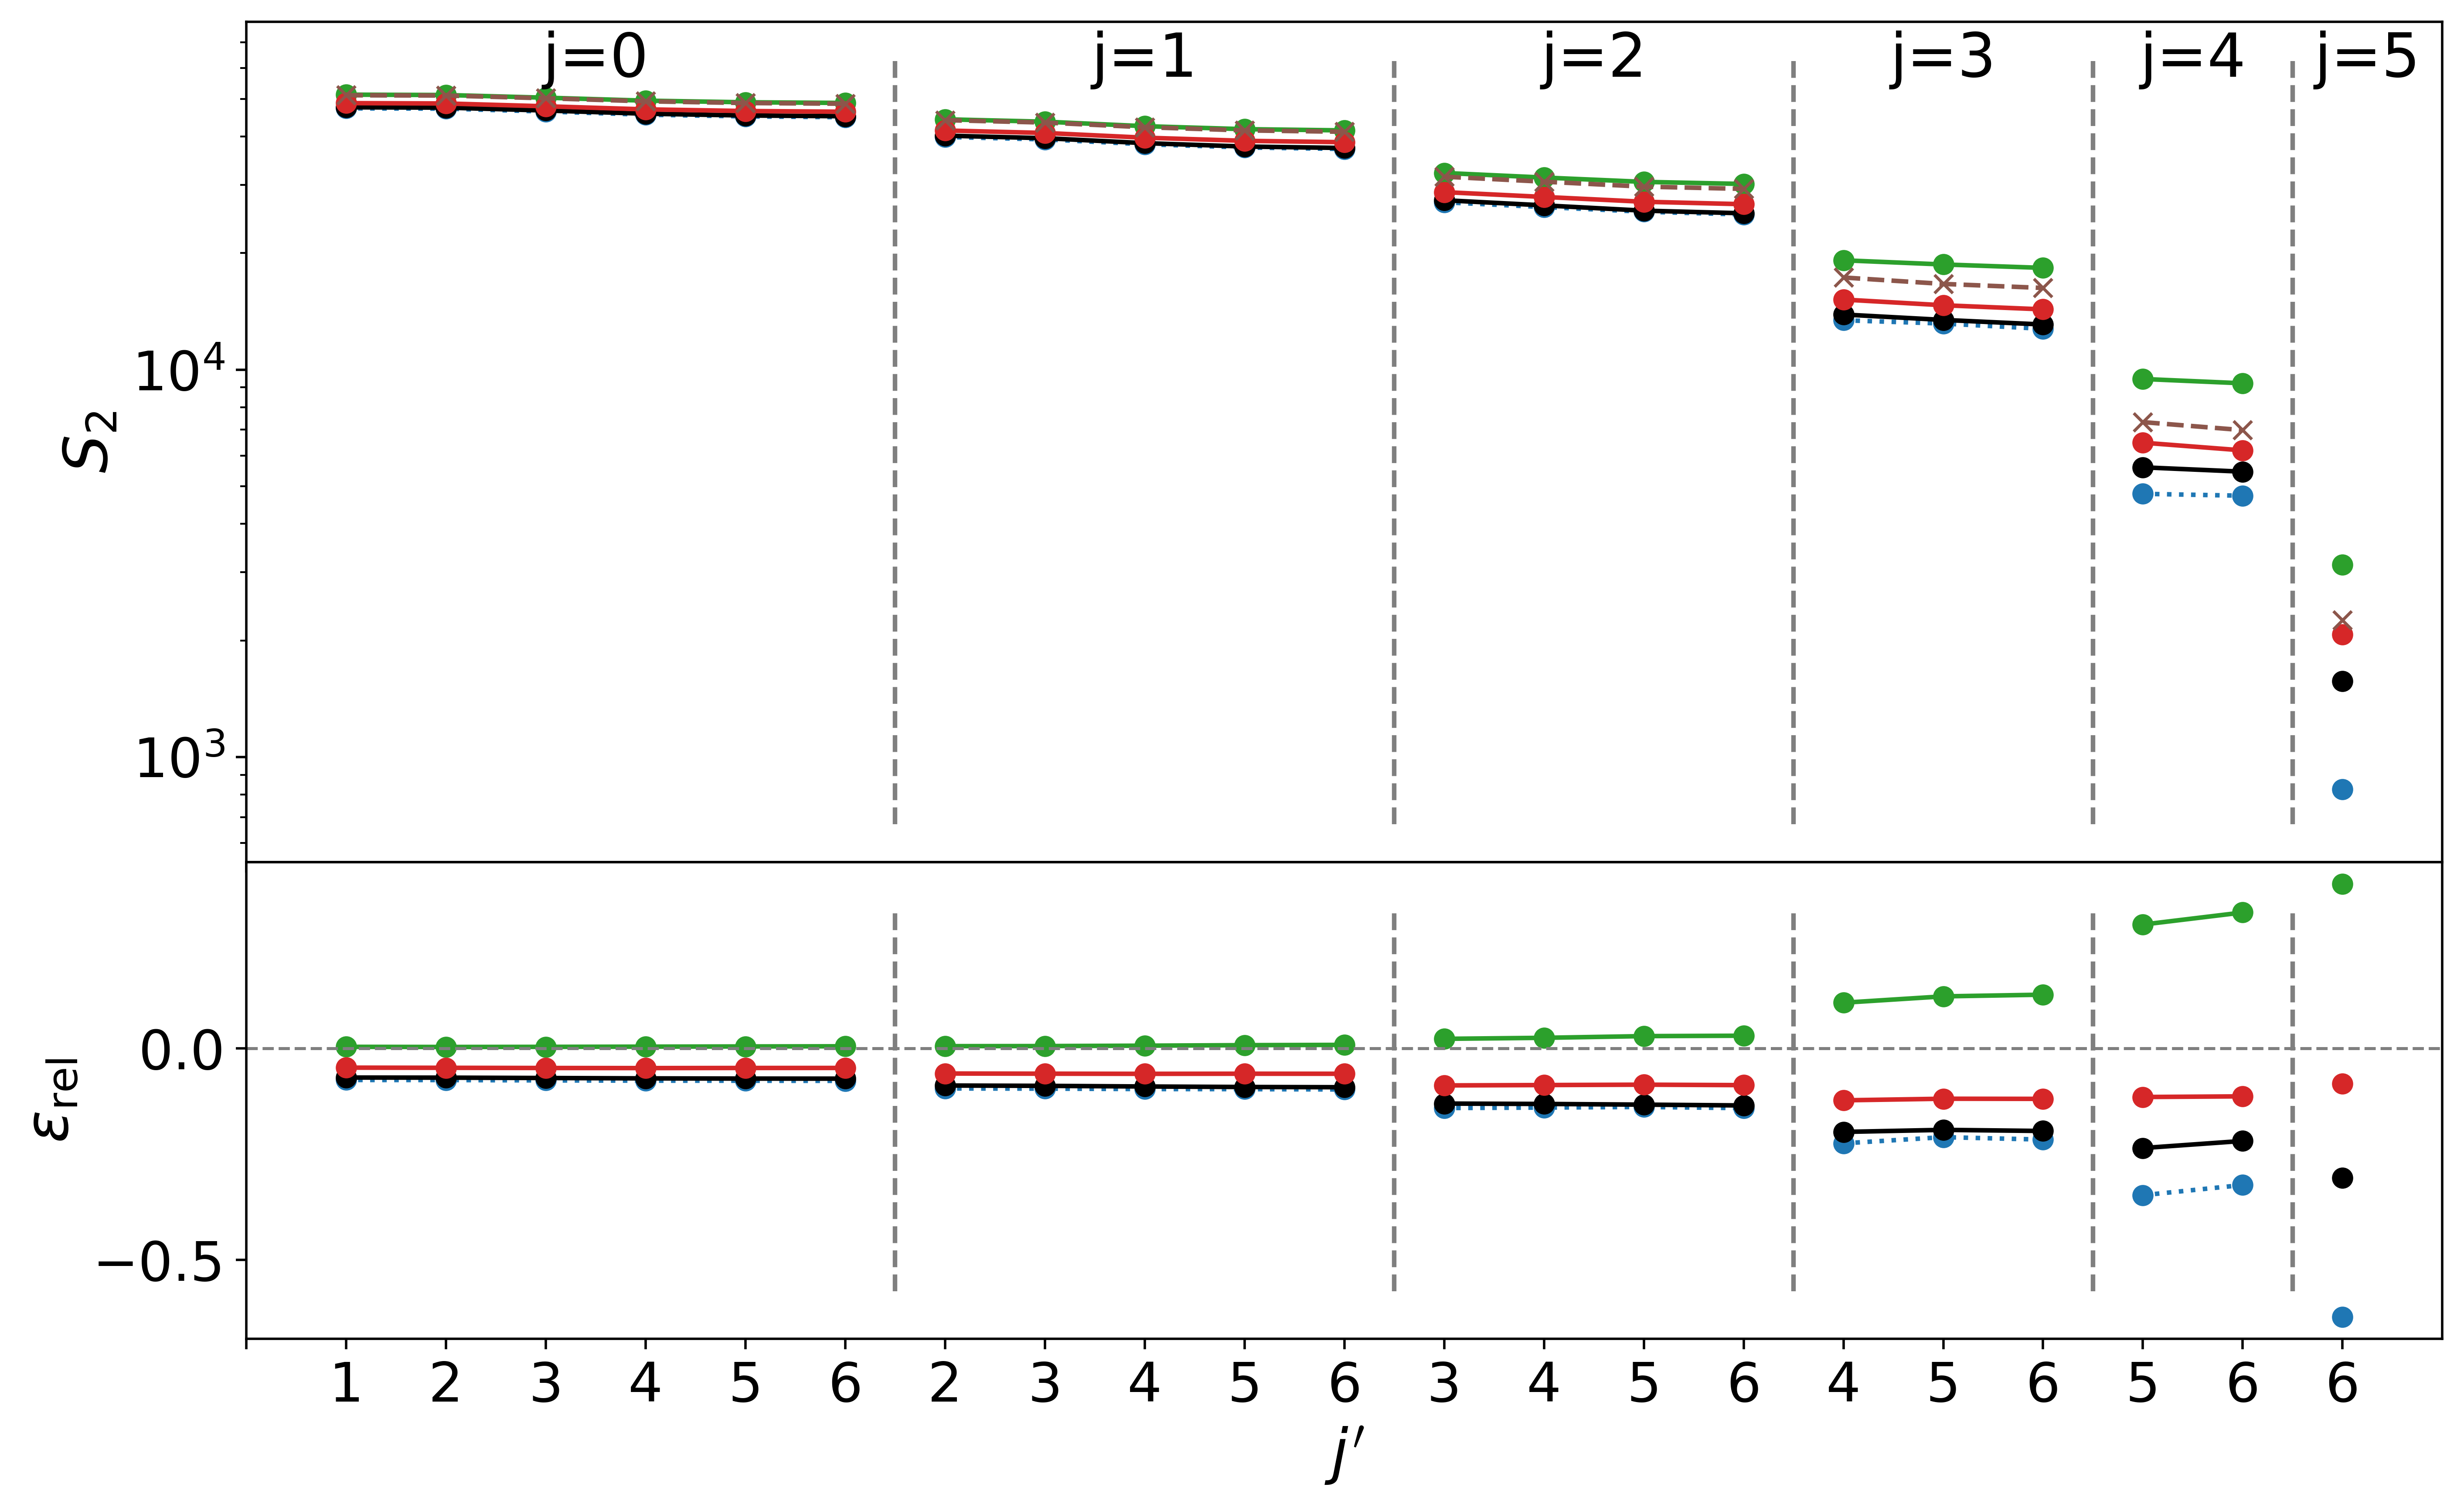

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex='col', 
                                                       figsize=(13,8), gridspec_kw={'height_ratios': [3, 1.7]},dpi=500)
fig.subplots_adjust(hspace=0, wspace=0.38)
#''''#1f77b4', '#ff7f0e', '#2ca02c', '#d62728''''
J=6
sums = J+1
for i in range(J):
    X = np.arange(J-i)
    idx = X+sums
    sums = sums+J-i
    X = X + sums - J-1 + i
    ax1.semilogy(X,SCP[idx],color = '#1f77b4',marker = 'o',linestyle = ':')
    ax1.semilogy(X,SHGP[idx],color = 'black',marker = 'o')
    ax1.semilogy(X,SHGP_np[idx],color = '#2ca02c',marker = 'o')
    ax1.semilogy(X,SNP[idx],color = '#d62728',marker = 'o')
    ax1.semilogy(X,Scos[idx],linestyle = '--',color = '#8c564b',marker = 'x')
    
    ax2.plot(X,SCP[idx]/Scos[idx]-1,color = '#1f77b4',marker = 'o',linestyle = ':')
    ax2.plot(X,SHGP[idx]/Scos[idx]-1,color = 'black',marker = 'o')
    ax2.plot(X,SHGP_np[idx]/Scos[idx]-1,color = '#2ca02c',marker = 'o')
    ax2.plot(X,SNP[idx]/Scos[idx]-1,color = '#d62728',marker = 'o')
    #ax1.semilogy(X,Scos[idx],linestyle = '--',color = '#8c564b',marker = 'x')

strs = ['  ']
for i in range(J):
    for j in range(J-i):
        strs.append(str(i+j+1))
ax2.set_xticks(range(5,27))
ax2.set_xticklabels(strs)

#next we plot separate lines
y_limits = ax1.get_ylim()

sums = 5.5
for i in range(J-1):
    sums = sums + J-i
    ax1.plot([sums,sums],list(y_limits),linestyle = '--', color='tab:grey')
    ax1.text(sums-(J-i)/2,6.3e4,'j='+str(i),ha='center',va='center',fontsize=20)
    ax2.axvline(sums,0.1,.9,linestyle = '--', color='tab:grey')
#plt.text(sums+0.75,1.6e4,'j='+str(i+1),ha='center',va='center',fontsize=22)
ax1.text(sums+0.75,6.3e4,'j='+str(i+1),ha='center',va='center',fontsize=20)
#plt.legend(['CP','HGP w/ pol','HGP w/o pol','NP w/ pol','True'])
ax1.set_ylabel(r'$S_2$',fontsize=20)
ax2.set_xlabel(r'$j^\prime$',fontsize=20)
ax2.set_ylabel(r'$\epsilon_{\rm rel}$',fontsize=20)

ax2.axhline(0.0,0,1,color = 'tab:grey',linewidth=1.0,linestyle = '--')

#plt.savefig('ST_s2.pdf',dpi=500,bbox_inches='tight')